In [62]:
#Process the WIDERFace dataset to create a classification dataset
import os
import numpy as np
from torchvision.datasets import WIDERFace
import torchvision.transforms.functional as trF
import torchvision.transforms as transforms

IMAGE_WIDTH = 88
IMAGE_HEIGHT = 88
MAX_FACES = 3

dataset_path = 'dataset'
dataset_output_path = 'dataset/classification'
split_selection = 'val' # 'train' or 'val' or 'test'

dataset = WIDERFace(dataset_path, split=split_selection, download=True)
print(f"Number of images in {split_selection} dataset: {len(dataset)}")

# Verify that the dataset is not already processed
nb_images = -1
already_processed = True
for i in range(MAX_FACES):
    path = f"{dataset_output_path}/{split_selection}/{i+1}"
    if os.path.exists(path):
        nb_images_folder = len(os.listdir(path))
        if nb_images == -1:
            nb_images = nb_images_folder
        elif nb_images != nb_images_folder:
            already_processed = False
            break
    else:
        already_processed = False
        break

if already_processed:
    print("Dataset already processed")
else:
    # Select only images with at most MAX_FACES faces
    for i in range(len(dataset)) :
        img, target = dataset[i]
        nb_faces = target['bbox'].shape[0]
        if nb_faces > MAX_FACES:
            continue

        w_img, h_img = img.size
        visible_faces = nb_faces
        for j in range(len(target['bbox'])):
            x, y, w, h = target['bbox'][j]
            occlusion = target['occlusion'][j]
            area = w/w_img * h/h_img * IMAGE_HEIGHT * IMAGE_WIDTH
            if area < 50 or occlusion >= 3:
                visible_faces = 0
                break
        
        if visible_faces <= 0:
            continue

        img = transforms.ToTensor()(img)
        img = trF.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
        img = trF.to_pil_image(img)
        save_path = f"{dataset_output_path}/{split_selection}/{visible_faces}"
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        img.save(f"{save_path}/{i}.jpg")
        if (i+1) % 1000 == 0:
            print(f"Processed {i+1} images over {len(dataset)}")

    # Equalize the number of images in each class
    nb_images = []
    for i in range(1, MAX_FACES+1):
        path = f"{dataset_output_path}/{split_selection}/{i}"
        files = os.listdir(path)
        nb_images.append(len(files))

    min_images = min(nb_images)

    for i in range(1, MAX_FACES+1):
        path = f"{dataset_output_path}/{split_selection}/{i}"
        files = os.listdir(path)
        to_remove = np.random.choice(len(files), len(files) - min_images, replace=False)
        for j in to_remove:
            os.remove(f"{path}/{files[j]}")

Files already downloaded and verified
Number of images in val dataset: 3226
Processed 2000 images over 3226


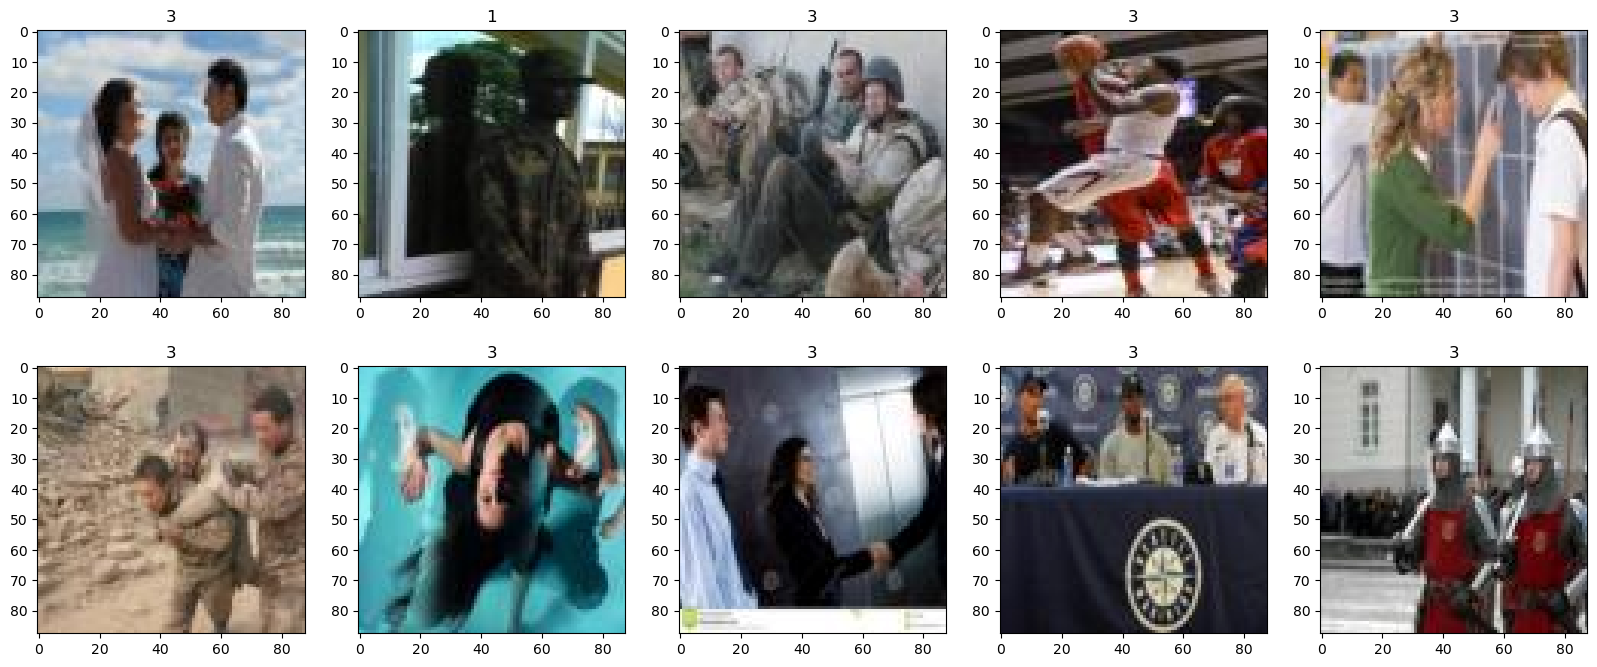

In [64]:
# Dataset class

import torch
import torch.utils.data as data
import os
from PIL import Image


NORMALIZE_MEAN = torch.tensor([0.485, 0.456, 0.406])
NORMALIZE_STD = torch.tensor([0.229, 0.224, 0.225])

class ClassificationDataset(data.Dataset):
    def __init__(self, root, split, transform=None):
        self.root = root
        self.split = split
        self.transform = transform
        self.classes = [d.name for d in os.scandir(f"{root}/{split}") if d.is_dir()]
        self.images = []
        for c in self.classes :
            class_path = os.path.join(f"{root}/{split}", c)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.images.append((image_path, c))
    
    def __getitem__(self, index):
        image_path, nb_faces = self.images[index]
        label = np.zeros(len(self.classes), dtype=np.float32)
        label[int(nb_faces)-1] = 1
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.tensor(label)
    
    def __len__(self):
        return len(self.images)
    
# Load the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

train_dataset = ClassificationDataset(dataset_output_path, 'train', transform)
val_dataset = ClassificationDataset(dataset_output_path, 'val', transform)

# Display some images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    img, label = train_dataset[np.random.randint(len(train_dataset))]
    axs[0, i].imshow((img * NORMALIZE_STD[:, None, None] + NORMALIZE_MEAN[:, None, None]).permute(1, 2, 0))
    axs[0, i].set_title(int(np.argmax(label)+1))
    img, label = val_dataset[i]
    axs[1, i].imshow((img * NORMALIZE_STD[:, None, None] + NORMALIZE_MEAN[:, None, None]).permute(1, 2, 0))
    axs[1, i].set_title(int(np.argmax(label)+1))

In [100]:
# Train a simple CNN
import torch.nn as nn
import torch.optim as optim
import torchsummary

class SimpleCNN(nn.Module):
    def __init__(self, num_channels=3, num_classes=MAX_FACES, dims=(IMAGE_HEIGHT, IMAGE_WIDTH)):
        super(SimpleCNN, self).__init__()
        self.h, self.w = dims
        self.c = 3
        
        self.conv1 = nn.Conv2d(num_channels, 8, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()
        self.c = 8 # output channels
        self.h //= 2 # padding = 1 -> same size, pool = 2 -> half size, h = 44
        self.w //= 2 # padding = 1 -> same size, pool = 2 -> half size, w = 44

        self.conv2 = nn.Conv2d(self.c, 16, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.ReLU()
        self.c = 16 # output channels
        self.h //= 2 # padding = 1 -> same size, pool = 2 -> half size, h = 22
        self.w //= 2 # padding = 1 -> same size, pool = 2 -> half size, w = 22

        self.conv3 = nn.Conv2d(self.c, 32, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.relu3 = nn.ReLU()
        self.c = 32 # output channels
        self.h //= 2 # padding = 1 -> same size, pool = 2 -> half size, h = 11
        self.w //= 2 # padding = 1 -> same size, pool = 2 -> half size, w = 11

        self.fc1 = nn.Linear(self.c * self.h * self.w, num_classes)
        self.out = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = nn.Dropout(0.25)(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = nn.Dropout(0.25)(x)
        x = self.pool3(self.relu3(self.conv3(x)))
        x = nn.Dropout(0.25)(x)
        x = x.view(-1, self.c * self.h * self.w)
        x = self.fc1(x)
        x = self.out(x)
        return x
    
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Summarize the model
model = SimpleCNN()
torchsummary.summary(model, (3, IMAGE_HEIGHT, IMAGE_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 88, 88]             224
              ReLU-2            [-1, 8, 88, 88]               0
         MaxPool2d-3            [-1, 8, 44, 44]               0
            Conv2d-4           [-1, 16, 44, 44]           1,168
              ReLU-5           [-1, 16, 44, 44]               0
         MaxPool2d-6           [-1, 16, 22, 22]               0
            Conv2d-7           [-1, 32, 22, 22]           4,640
              ReLU-8           [-1, 32, 22, 22]               0
         MaxPool2d-9           [-1, 32, 11, 11]               0
           Linear-10                    [-1, 3]          11,619
          Softmax-11                    [-1, 3]               0
Total params: 17,651
Trainable params: 17,651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/ba

In [101]:
from tqdm import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define training function with progress bar
def train(model, loader, optimizer, loss_fn, epoch, num_epochs):
    model.train()
    total_loss = 0
    # Add a tqdm progress bar for training batches
    with tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False) as pbar:
        for i, (images, targets) in enumerate(pbar):
            images = images.to(device)  # Move data to correct device
            targets = targets.to(device)  # Move targets to correct device
            
            optimizer.zero_grad() # Zero the gradients
            outputs = model(images) # Forward pass

            loss = loss_fn(outputs, targets) # Compute the loss
            loss.backward()  #| Backward pass and optimization
            optimizer.step() #|

            total_loss += loss.item()
            pbar.set_postfix(loss=total_loss / (i + 1)) # Update the progress bar
    return total_loss / len(loader)

# Define validation function
def validate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(loader)

# Compute the accuracy
def accuracy(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            _, targets = torch.max(targets, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

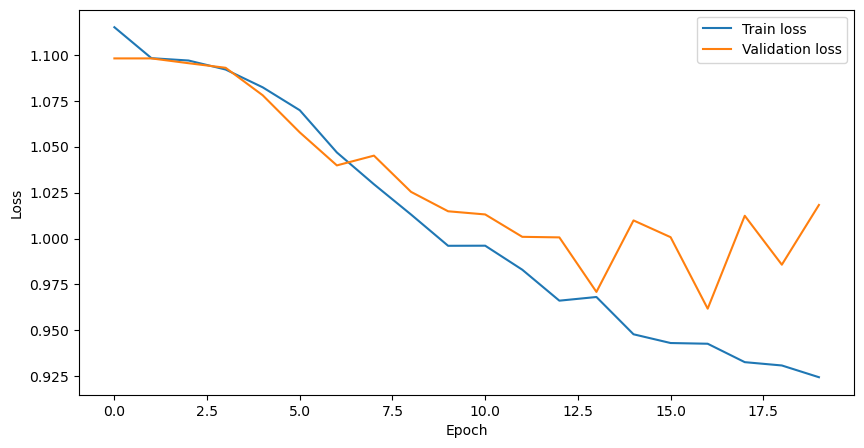

In [104]:
batch_size = 50
data_loader_train = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
data_loader_val = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

model = SimpleCNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, data_loader_train, optimizer, loss_fn, epoch, num_epochs)
    val_loss = validate(model, data_loader_val, loss_fn)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


# Save the model
models_path = "models"
model_name = "simple_cnn"
if not os.path.exists(models_path):
    os.makedirs(models_path)
torch.save(model.state_dict(), os.path.join(models_path, model_name))

In [105]:
# Load the model
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(os.path.join(models_path, model_name)))
model.eval()

train_accuracy = accuracy(model, data_loader_train)
val_accuracy = accuracy(model, data_loader_val)
print(f"Train accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")

/tmp/ipykernel_17670/2223813813.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(models_path, model_name)))


Train accuracy: 0.6394557823129252
Validation accuracy: 0.4904214559386973
